# Intermediate Linear Regression Practice

## Use a Linear Regression model to get the lowest RMSE possible on the following dataset:

[Dataset Folder](https://github.com/ryanleeallred/datasets/tree/master/Ames%20Housing%20Data)

[Raw CSV](https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv)

## You model must include (at least):
- A log-transformed y variable
- Two polynomial features
- One interaction feature
- 10 other engineered features

What is the lowest Root-Mean-Squared Error that you are able to obtain? Share your best RMSEs in Slack!

Notes:

There may be some data cleaning that you need to do on some features of this dataset. Linear Regression will only accept numeric values and will not accept

Note* There may not be a clear candidate for an interaction term in this dataset. Include one anyway, sometimes it's a good practice for predictive modeling feature engineering in general. 

In [5]:
from sklearn import preprocessing, model_selection, impute, metrics, linear_model
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import collections
import re

#### Load Data

In [6]:
housing_data_url = 'https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv'
houses = pd.read_csv(housing_data_url)

#### Replace `NaN`'s in Categorical Columns

In [7]:
houses['Alley'] = houses['Alley'].fillna('Nothing')
houses['Fence'] = houses['Fence'].fillna('No Fence')
houses['PoolQC'] = houses['PoolQC'].fillna('No Pool')
houses['GarageYrBlt'] = houses['GarageYrBlt'].fillna(0)
houses['MiscFeature'] = houses['MiscFeature'].fillna('None')
houses['MasVnrType'] = houses['MasVnrType'].fillna('Unknown')
houses['Electrical'] = houses['Electrical'].fillna('Unknown')
houses['FireplaceQu'] = houses['FireplaceQu'].fillna('No Fireplace')

houses = houses.assign(
    **houses[[col for col in houses.columns.values if 'Bsmt' in col]]\
        .fillna('No Basement')\
        .to_dict(orient='series')
)

houses = houses.assign(
    **houses[[col for col in houses.drop(columns='GarageYrBlt').columns.values if 'Garage' in col]]\
        .fillna('No Garage')\
        .to_dict(orient='series')
)

#### Convert Columns To Snake Case

In [8]:
def snakecase(word):
    return re.sub(r"(?<!^)([A-Z][a-z0-9]+)", r"_\1", word).lower()

In [9]:
print(snakecase('VSCode'), snakecase('SQL'), snakecase('PaulGraham'))

vs_code sql paul_graham


In [10]:
cols = houses.columns.values
snake_case = [snakecase(col) for col in cols]
houses = houses.rename(columns={old: new for old, new in zip(cols, snake_case)})

#### Encode Categorical Variables To Numeric Values

In [11]:
# encode categorical values
encoder = preprocessing.LabelEncoder()
encoded_houses = houses.assign(
    **houses\
        .select_dtypes(np.object)\
        .apply(encoder.fit_transform)\
        .to_dict(orient='series')
)

#### Determine The Bias-Variance Tradeoff Using Different `NaN` Handling Methods

In [12]:
nanhandler = collections.namedtuple("NanHandler", ("method", "dataframe"))

nanhanders = [
    nanhandler('drop', encoded_houses.dropna()),
    nanhandler('zero', encoded_houses.fillna(0)),
    nanhandler('mean', encoded_houses.apply(lambda col: col.fillna(col.mean()))),
    nanhandler('median', encoded_houses.apply(lambda col: col.fillna(col.median())))
]

#### TODO: Impute NaNs via Linear Regression

In [28]:
def impute_nans_via_regression(df, column):
    regressor = linear_model.LinearRegression()
    
    is_na = df[column].isna()
    is_not_na = ~is_na
    
    df = df.astype(np.int, errors='ignore')

    X = df.drop(columns=column)
    y = df[column]
    
    X_train = X[is_not_na].dropna()
    y_train = y[is_not_na].dropna()
    
    X_test = X[is_na]
    
    regressor.fit(X_train, y_train)
    
    return y_train, regressor.predict(X_test)

In [ ]:
encoded_houses.apply(
    lambda col: linear_model.LinearRegression().fit(encoded_houses.drop(columns=col.name), col).predict()
)

#### Test NaN Handling Methods

In [13]:
batches = 30

In [14]:
splitdata = collections.namedtuple("SplitData", ("X", "y", "X_train", "X_test", "y_train", "y_test"))
regressor = linear_model.LinearRegression()
scores = {}

for handler in nanhanders:
    df = handler.dataframe
    X = df.drop(columns='sale_price')
    y = df.sale_price
    data = splitdata(X, y, *model_selection.train_test_split(X, y))
    validation = model_selection.cross_validate(
        regressor, 
        data.X, 
        data.y, 
        cv=batches, 
        scoring=('r2', 'neg_mean_squared_error'),
        return_train_score=True
    )
        
    scores[handler.method] = pd.DataFrame({key: pd.Series(val) for key, val in validation.items()})
    
scores = pd.concat(scores.values(), keys=scores.keys())

In [15]:
scores.head()

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
drop 0  0.043994    0.007966  0.903166  0.858810                -5.811491e+08   
     1  0.028488    0.009601  0.908118  0.858725                -5.434122e+08   
     2  0.008577    0.005278  0.892457  0.859676                -4.374896e+08   
     3  0.009382    0.003403  0.894323  0.857570                -1.113127e+09   
     4  0.015705    0.003742  0.555954  0.864226                -2.910953e+09   

        train_neg_mean_squared_error  
drop 0                 -9.800374e+08  
     1                 -9.805338e+08  
     2                 -9.833322e+08  
     3                 -9.638384e+08  
     4                 -9.399404e+08

#### Distance Between The Training And Test RMSE For Each `NaN` Handling Method

In [16]:
scores['test_rmse'] = np.sqrt(-1*scores.test_neg_mean_squared_error)
scores['train_rmse'] = np.sqrt(-1*scores.train_neg_mean_squared_error)
scores['rmse_degree_of_overfit'] = np.sqrt(np.power(scores.train_rmse - scores.test_rmse, 2))

#### RMSE Distance Across Each Cross-Validation Run, For Each `NaN` Handling Method

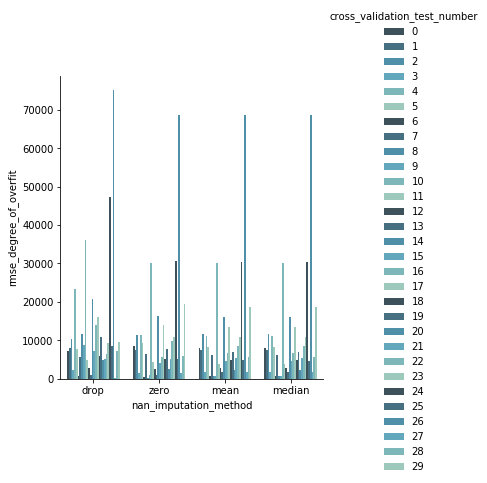

In [14]:
sns.catplot(
    y='rmse_degree_of_overfit',
    x='nan_imputation_method',
    hue='cross_validation_test_number',
    kind='bar',
    palette=sns.color_palette("GnBu_d"),
    data=scores.reset_index().rename(columns={
        'level_0': 'nan_imputation_method', 
        'level_1': 'cross_validation_test_number'
    })
)

#### Average RMSE Distance For Each `NaN` Handling Method

In [ ]:
overfit_distribution = scores[['rmse_degree_of_overfit']]\
    .reset_index()\
    .rename(columns={
        'level_0': 'nan_imputation_method', 
        'level_1': 'cross_validation_test_number'
    })\
    .groupby('nan_imputation_method')

Text(0.5,1,'Average Test Set Overfit per NaN Imputation Method')

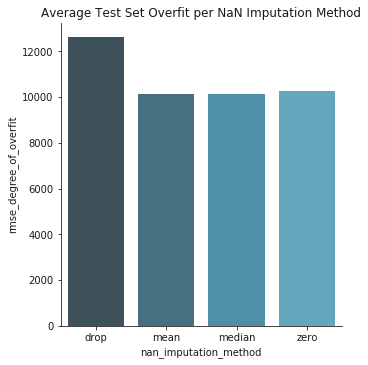

In [590]:
# This shows the average distance between the RMSE errors of the training and 
# test datasets, as randomly distributed using 30 cross validation trials. We
# can see that the distance between the error is greatest when we drop the nan
# values as opposed to filling them in with the mean of the dataset at hand which
# minimizes the distance. This doesn't necessairily mean that filling in with the
# mean is better so much as it reduces variance. 

sns.catplot(
    y='rmse_degree_of_overfit',
    x='nan_imputation_method',
    kind='bar',
    palette=sns.color_palette("GnBu_d"),
    data=overfit_distribution.mean().reset_index()
)

plt.title("Average Test Set Overfit per NaN Imputation Method")

#### Median RMSE Distance For Each `NaN` Handling Method

Text(0.5,1,'Median Test Set Overfit per NaN Imputation Method')

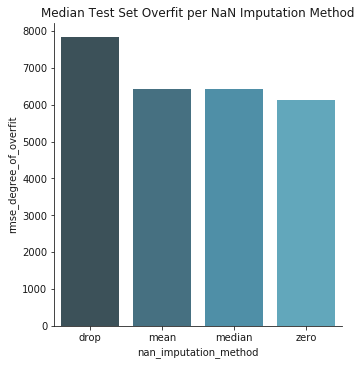

In [592]:
sns.catplot(
    y='rmse_degree_of_overfit',
    x='nan_imputation_method',
    kind='bar',
    palette=sns.color_palette("GnBu_d"),
    data=overfit_distribution.median().reset_index()
)

plt.title("Median Test Set Overfit per NaN Imputation Method")

#### Distribution of RMSE Distances from Training To Test 

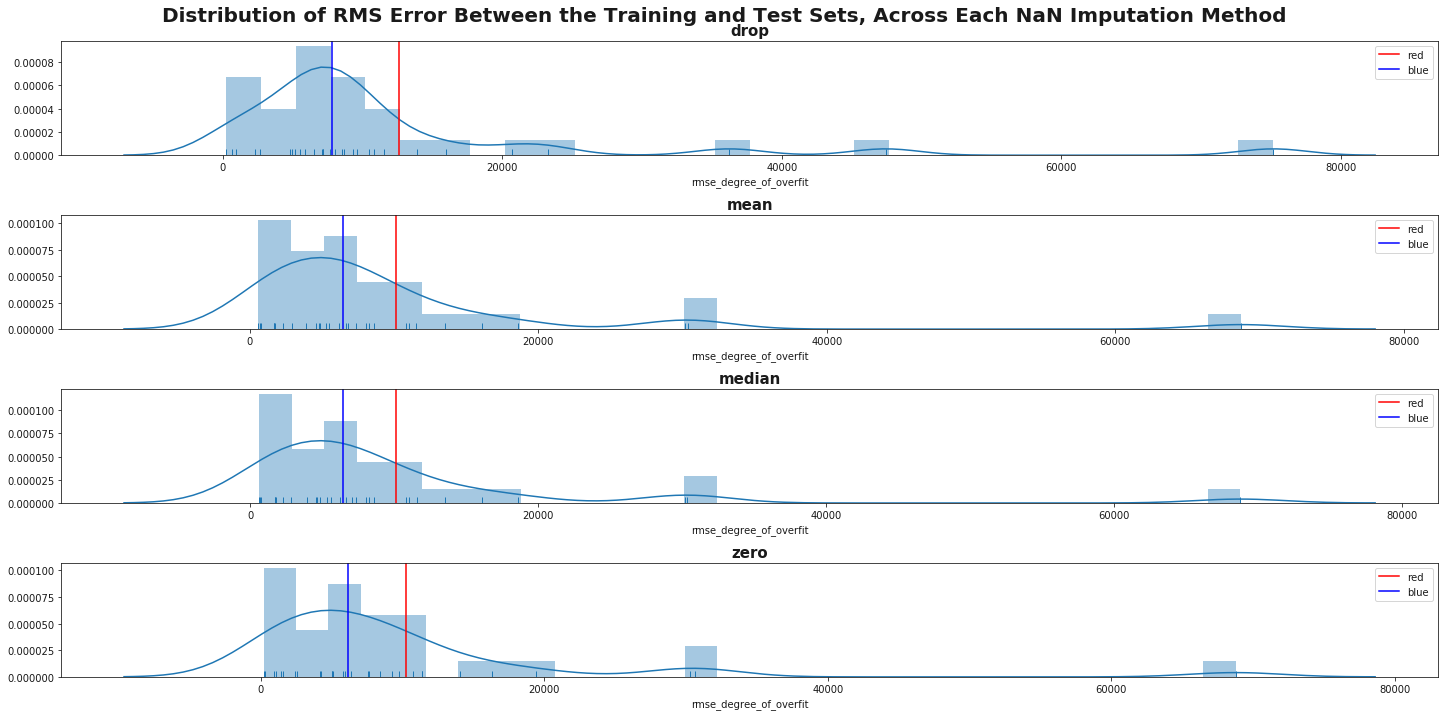

In [725]:
sns.set_color_codes()

i = 0
fig, axes = plt.subplots(4, 1, figsize=(20,10), constrained_layout=True)

fig.suptitle(
    "Distribution of RMS Error Between the Training and Test Sets, Across Each NaN Imputation Method", 
    fontsize=20, 
    weight='bold'
)

for ax, (label, group) in zip(axes, overfit_distribution):
    i += 1
    overfit = group.rmse_degree_of_overfit
    mean = overfit.mean()
    median = overfit.median()
        
    bx = sns.distplot(overfit, ax=ax, bins=batches, rug=True)
    bx.axvline(mean, color='red')
    bx.axvline(median, color='blue')
    bx.set_title(label, fontsize=15, weight='bold')
    bx.legend({'red': 'mean', 'blue': 'median'})

#### Linear Regression Accuracy Without Any Feature Engineering

In [17]:
mean_filled_housing = encoded_houses.apply(lambda col: col.fillna(col.mean()))
X = mean_filled_housing.drop(columns='sale_price')
y = mean_filled_housing.sale_price

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [18]:
regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [19]:
print("""
Test Set, No Feature Engineering: 
 R^2: {}
 MSE: {}
 RMSE: {}"""\
      .format(
        metrics.r2_score(y_test, regressor.predict(X_test)),
        metrics.mean_squared_error(y_test, regressor.predict(X_test)),
        np.sqrt(metrics.mean_squared_error(y_test, regressor.predict(X_test)))
    )
)


Test Set, No Feature Engineering: 
 R^2: 0.8505004589847918
 MSE: 838215123.6576242
 RMSE: 28951.945075549316


#### Linear Regression Accuracy W/ Outlier Removal

In [20]:
mean_filled_housing = encoded_houses.apply(lambda col: col.fillna(col.mean()))

outlier_free = mean_filled_housing[np.abs(stats.zscore(mean_filled_housing)) < 2]

X = outlier_free.drop(columns='sale_price')
y = outlier_free.sale_price

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [21]:
regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [22]:
print("""
Test Set, No Feature Engineering: 
 R^2: {}
 MSE: {}
 RMSE: {}"""\
      .format(
        metrics.r2_score(y_test, regressor.predict(X_test)),
        metrics.mean_squared_error(y_test, regressor.predict(X_test)),
        np.sqrt(metrics.mean_squared_error(y_test, regressor.predict(X_test)))
    )
)


Test Set, No Feature Engineering: 
 R^2: 0.8520545575091987
 MSE: 882139617.6605548
 RMSE: 29700.835302404455


#### Linear Regression w/ Log-Transformed Y-Value

In [23]:
X = outlier_free.drop(columns='sale_price')
y = np.log10(outlier_free.sale_price)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [24]:
regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [23]:
print("""
Test Set, No Feature Engineering: 
 R^2: {}
 MSE: {}
 RMSE: {}"""\
      .format(
        metrics.r2_score(y_test, regressor.predict(X_test)),
        metrics.mean_squared_error(y_test, regressor.predict(X_test)),
        np.sqrt(metrics.mean_squared_error(y_test, regressor.predict(X_test)))
    )
)


Test Set, No Feature Engineering: 
 R^2: 0.8871596007771698
 MSE: 0.00326088840383417
 RMSE: 0.05710418902177116


#### Linear Regression w/ 10 Engineered Features

In [25]:
engineered = outlier_free.copy(deep=True)

In [26]:
engineered['total_porch_sf'] = outlier_free.wood_decksf + outlier_free.open_porchsf + outlier_free.enclosed_porch + outlier_free['3_ssn_porch'] + outlier_free.screen_porch
engineered['has_pool'] = outlier_free.pool_area != 0
engineered['has_porch'] = engineered['total_porch_sf'] != 0
engineered['has_porch_and_pool'] = engineered['has_pool'] & engineered['has_porch']
engineered['total_bathrooms'] = outlier_free['bsmt_full_bath'] + (outlier_free['bsmt_half_bath']*0.5) + outlier_free['full_bath'] + (outlier_free['half_bath']*0.5)
engineered['lot_size'] = (outlier_free['lot_frontage']*0.1) + outlier_free['lot_area']
engineered['frontage_to_lot'] = outlier_free['lot_frontage']/outlier_free['lot_area']
engineered['age_since_remodel'] = 2015 - outlier_free['year_remod_add']
engineered['age'] = 2015 - outlier_free['year_built']
engineered['total_floor_square_feet'] = outlier_free['1st_flrsf'] + outlier_free['2nd_flrsf'] + outlier_free['total_bsmtsf']
engineered['relatively_new'] = engineered['age'] < 5
engineered['just_built'] = engineered['age'] == 0

In [27]:
X = engineered.drop(columns='sale_price')
y = np.log10(engineered.sale_price)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [28]:
regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [30]:
print("""
Test Set, No Feature Engineering: 
 R^2: {}
 MSE: {}
 RMSE: {}"""\
      .format(
        metrics.r2_score(y_test, regressor.predict(X_test)),
        metrics.mean_squared_error(y_test, regressor.predict(X_test)),
        np.sqrt(metrics.mean_squared_error(y_test, regressor.predict(X_test)))
    )
)


Test Set, No Feature Engineering: 
 R^2: 0.9026713590675896
 MSE: 0.0028471629818683456
 RMSE: 0.053358813535051036


#### Linear Regression w/ 2 Polynomial Features

In [33]:
polynomial = engineered.copy(deep=True)

In [34]:
polynomial['lot_size_squared'] = engineered['lot_size']**2
polynomial['garage_cars_squared'] = engineered['garage_cars']**2

In [35]:
X = polynomial.drop(columns='sale_price')
y = np.log10(polynomial.sale_price)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [36]:
regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [37]:
print("""
Test Set, No Feature Engineering: 
 R^2: {}
 MSE: {}
 RMSE: {}"""\
      .format(
        metrics.r2_score(y_test, regressor.predict(X_test)),
        metrics.mean_squared_error(y_test, regressor.predict(X_test)),
        np.sqrt(metrics.mean_squared_error(y_test, regressor.predict(X_test)))
    )
)


Test Set, No Feature Engineering: 
 R^2: 0.9057756909593517
 MSE: 0.0027758205897824434
 RMSE: 0.0526860568820864


#### Linear Regression w/ 1 Interaction Feature

In [49]:
interaction = polynomial.copy(deep=True)

In [50]:
interaction['200x_total_bathrooms'] = polynomial['total_bathrooms']*200

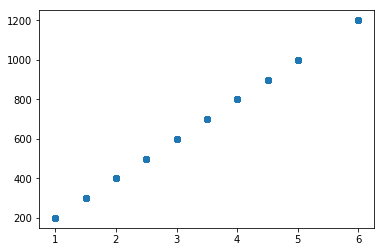

In [51]:
plt.scatter(interaction['total_bathrooms'], interaction['200x_total_bathrooms'])

In [52]:
X = interaction.drop(columns='sale_price')
y = np.log10(interaction.sale_price)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [53]:
regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [54]:
print("""
Test Set, No Feature Engineering: 
 R^2: {}
 MSE: {}
 RMSE: {}"""\
      .format(
        metrics.r2_score(y_test, regressor.predict(X_test)),
        metrics.mean_squared_error(y_test, regressor.predict(X_test)),
        np.sqrt(metrics.mean_squared_error(y_test, regressor.predict(X_test)))
    )
)


Test Set, No Feature Engineering: 
 R^2: 0.9005597152320604
 MSE: 0.0028988550661543187
 RMSE: 0.05384101657801716


#### Box Plot Of Sales Prices Per Year

In [669]:
houses['date_sold'] = pd.to_datetime(houses.yr_sold.astype('str') + "-" + houses.mo_sold.astype('str'))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]), <a list of 55 Text xticklabel objects>)

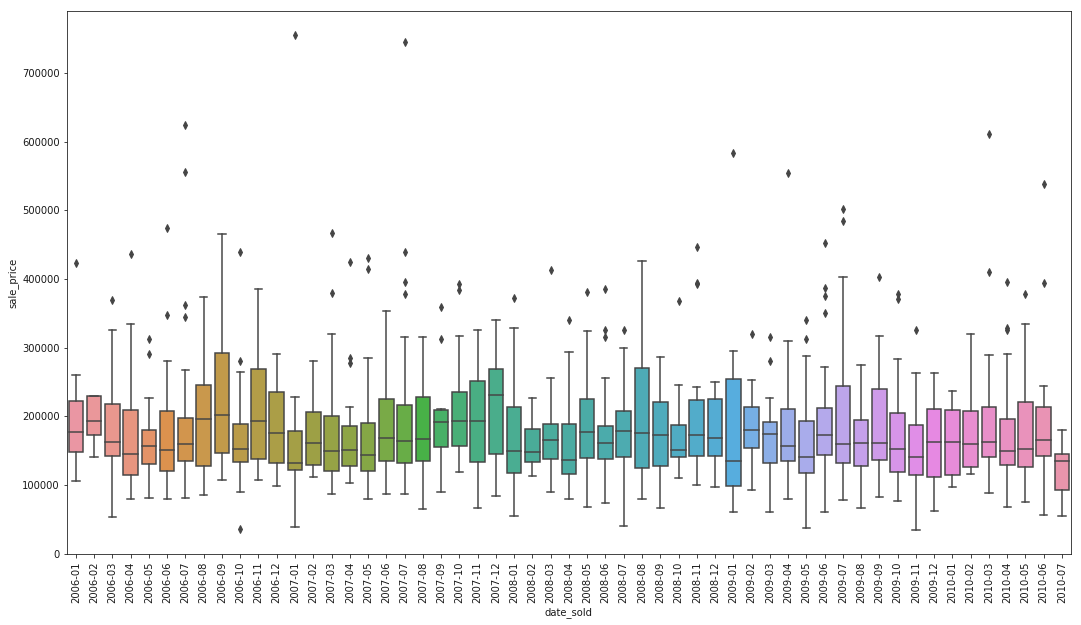

In [684]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10))

bx = sns.boxplot(
    y=houses.sale_price,
    x=houses.date_sold.dt.strftime("%Y-%m").sort_values(),
    ax=ax
)

plt.xticks(rotation=90)

#### Verifying The Log-Normal Structure Of `sale_price`

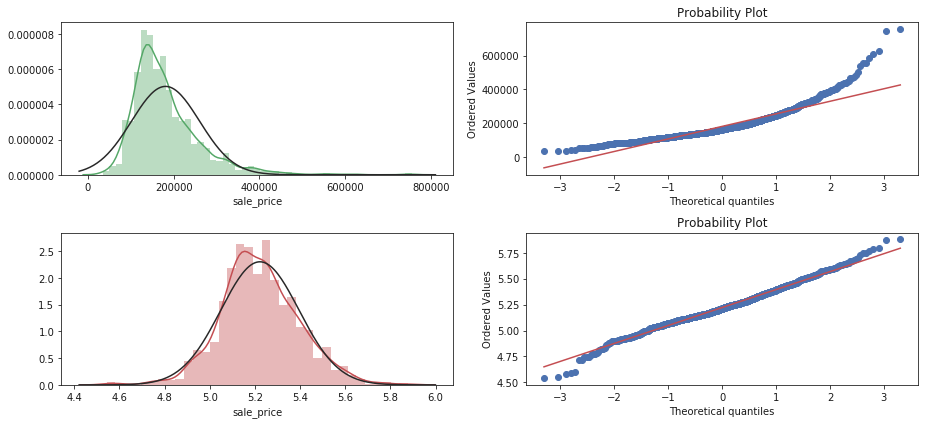

In [710]:
fig, (ax, bx) = plt.subplots(2, 2, figsize=(13, 6))

sns.distplot(housing.sale_price, fit=stats.norm, ax=ax[0], color='g')
res = stats.probplot(housing.sale_price, plot=ax[1])

sns.distplot(np.log10(housing.sale_price), fit=stats.norm, ax=bx[0], color='r')
res = stats.probplot(np.log10(housing.sale_price), plot=bx[1])

plt.tight_layout()

# Stretch Goals

- Write a blog post explaining one of today's topics.
- Find a new regression dataset from the UCI machine learning repository and use it to test out your new modeling skillz.
 [ - UCI Machine Learning Repository - Regression Datasets](https://)
- Make a list for yourself of common feature engineering techniques. Browse Kaggle kernels to learn more methods.
- Start studying for tomorrow's topic: Gradient Descent
- Try and make the ultimate model with this dataset. clean as many features as possible, engineer the most sensible features as possible and see how accurate of a prediction you can make. 
- Learn about the "Dummy Variable Trap" and how it applies to linear regression modeling.
- Learning about using linear regression to model time series data